In [1]:
import os
import sys

# code for enabling this notebook to work within cursor
coralme_dir = '/home/chris/zuniga/coralme/'
sys.path.insert(0, coralme_dir)

import importlib
import coralme
import coralme.solver.solver
import coralme.builder.main
import coralme.core.model
import os
import pandas as pd
import json
import cobra
import numpy as np
import matplotlib.pyplot as plt
from coralme.util.helpers import get_nlp, optimize
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from coralme.builder.main import MEBuilder

In [2]:
# go through each model to generate solutions
base_dir = os.path.join(coralme_dir, 'species_files', 'Pseudomonas_files')
info_df = pd.read_excel(os.path.join(base_dir,'Strain_models_genome-information_predictedM9.xlsx'), index_col = 0)
for index, row in info_df.iterrows():
    if index == 'Reference': continue

    # check if model exists and solution not already saved off
    out_dir = base_dir+'/individual_species/'+index+'/'
    model_name = row['organism'].replace(' ', '_')+'_'+row['strain'].replace(' ','_')
    out_model = out_dir+'/outputs/MEModel-step3-'+model_name+'-TS.pkl'
    out_sol = out_dir+'/outputs/saved_solution.pkl'
    if not os.path.exists(out_model):
        print(str(index)+' skipped, model doesn\'t yet exist')
        continue
    if os.path.exists(out_sol):
        print(str(index)+' skipped, solution already exists')
        continue

    # load model, run model
    ME_model = coralme.io.pickle.load_pickle_me_model(out_model)
    ME_model.optimize(tolerance = 1e-3)
    try:
        ME_sol = ME_model.solution
    except:
        ME_sol = None

    # save the solution off
    pickle_out = open(out_sol, 'wb')
    pickle.dump(ME_sol, pickle_out)
    pickle_out.close()

CP065866 skipped, solution already exists
CP041013 skipped, solution already exists
CP039749 skipped, solution already exists
CP065865 skipped, solution already exists
CP065867 skipped, solution already exists
LR590473 skipped, solution already exists
CP008749.1 skipped, solution already exists
AE004091.2 skipped, solution already exists
CP068238 skipped, solution already exists
CP014784 skipped, solution already exists
CP061848 skipped, solution already exists
CP061335 skipped, solution already exists
CP053697 skipped, solution already exists
CP070982 skipped, solution already exists
LS483372 skipped, solution already exists
CP012830 skipped, solution already exists
CP012831 skipped, solution already exists
CP008896 skipped, solution already exists
CP015225 skipped, solution already exists
CP060288 skipped, solution already exists
CP022562 skipped, solution already exists
CP050291 skipped, solution already exists
CP043179 skipped, solution already exists
AP024503 skipped, solution alr

In [3]:
# go through each model to create a dataframe of reduced and shadow prices
base_dir = os.path.join(coralme_dir, 'species_files', 'Pseudomonas_files')
info_df = pd.read_excel(os.path.join(base_dir,'Strain_models_genome-information_predictedM9.xlsx'), index_col = 0)
shadows_dfs = []
reduced_dfs = []
indices = []
obj_values = []
for index, row in info_df.iterrows():
    if index == 'Reference': continue

    # check if model exists and solution not already saved off
    out_dir = base_dir+'/individual_species/'+index+'/'
    out_sol = out_dir+'/outputs/saved_solution.pkl'
    if not os.path.exists(out_sol):
        print(str(index)+' skipped, solution doesn\'t yet exist')
        continue

    # load solution
    pickle_in = open(out_sol, 'rb')
    ME_sol = pickle.load(pickle_in)
    pickle_in.close()
    if ME_sol:
        indices.append(index)
        shadows_dfs.append(pd.Series(ME_sol.shadow_prices))
        reduced_dfs.append(pd.Series(ME_sol.reduced_costs))
        obj_values.append(ME_sol.objective_value)

# remove dummy reactions
drop_words = ['dummy', 'CPLX']
shadow_df = pd.DataFrame(shadows_dfs, index = indices)
shared_cols = shadow_df.columns[shadow_df.count() == len(shadow_df)]
keep = []
for col in shared_cols:
    if not any(word in col for word in drop_words):
        keep.append(col)
shadow_df = shadow_df[keep]

shadow_df['obj_value'] = obj_values
shadow_df.iloc[:, :-1] = shadow_df.iloc[:, :-1].div(shadow_df['obj_value'], axis=0)
reduced_df = pd.DataFrame(reduced_dfs, index = indices)
shared_cols = reduced_df.columns[reduced_df.count() == len(reduced_df)]
keep = []
for col in shared_cols:
    if not any(word in col for word in drop_words):
        keep.append(col)
reduced_df = reduced_df[keep]
reduced_df['obj_value'] = obj_values
reduced_df.iloc[:, :-1] = reduced_df.iloc[:, :-1].div(reduced_df['obj_value'], axis=0)

# look at top shadow prices and reduced costs

In [6]:
len(reduced_df)

26

# logistic regression - results in really poor accuracy

/home/chris/miniforge3/envs/coralme/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report:
                         precision    recall  f1-score   support

 Pseudomonas aeruginosa       1.00      1.00      1.00         2
   Pseudomonas asiatica       0.00      0.00      0.00         1
Pseudomonas fluorescens       0.50      1.00      0.67         1
  Pseudomonas mendocina       0.00      0.00      0.00         1
  Pseudomonas monteilii       0.00      0.00      0.00         0

               accuracy                           0.60         5
              macro avg       0.30      0.40      0.33         5
           weighted avg       0.50      0.60      0.53         5



/home/chris/miniforge3/envs/coralme/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chris/miniforge3/envs/coralme/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chris/miniforge3/envs/coralme/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

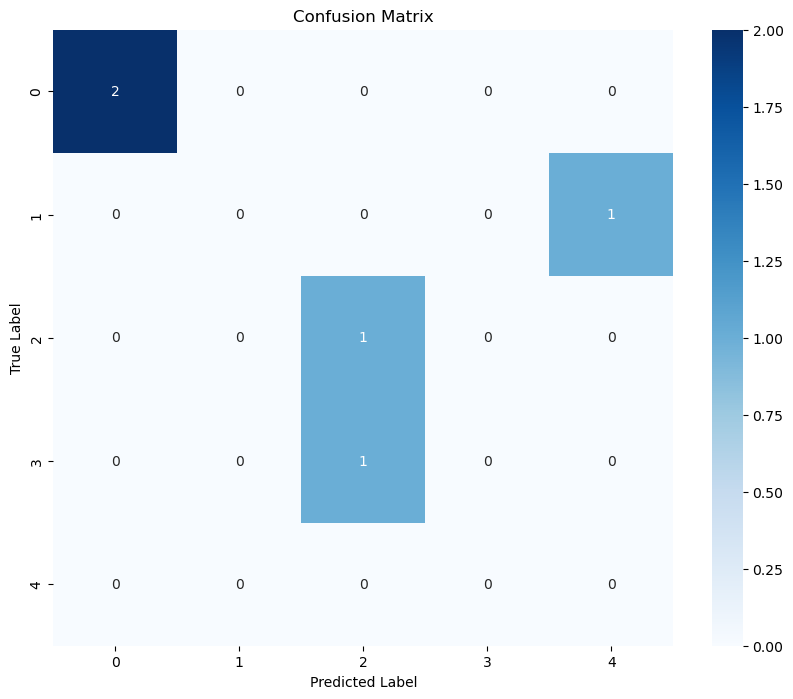

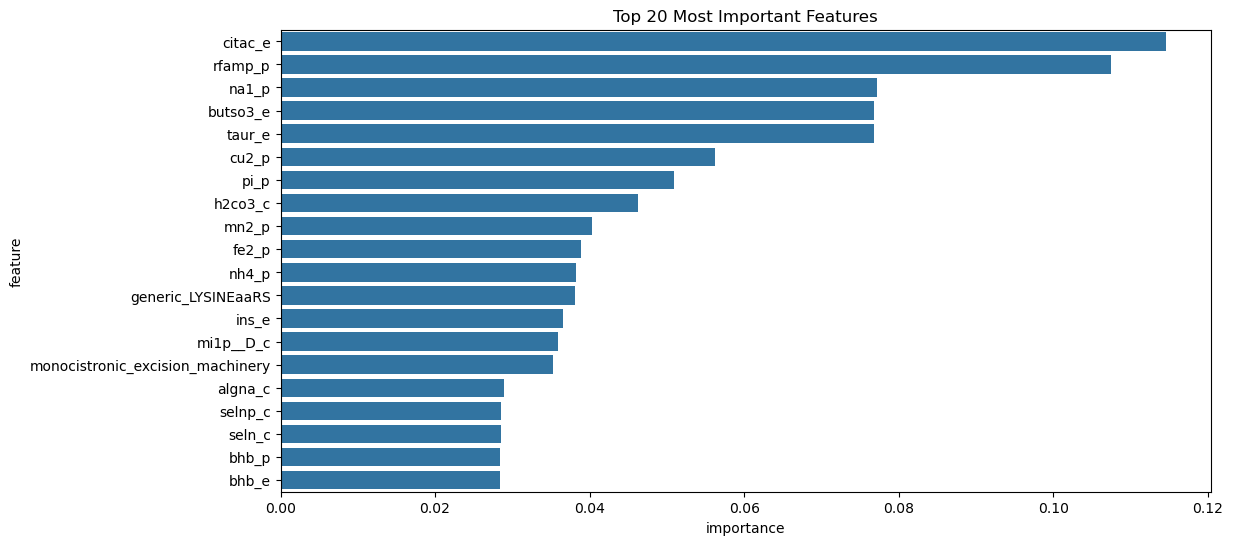

In [7]:
# Get the organism labels from info_df
y = info_df.loc[shadow_df.index, 'organism']

# Prepare the features (reduced costs)
X = shadow_df.drop('obj_value', axis=1)  # Remove the objective value column

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the logistic regression model
model = LogisticRegression(multi_class='multinomial', max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(model.coef_).mean(axis=0)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.show()

In [58]:
reduced_df['EX_pheme_e']

CP065866      0.000000e+00
CP041013     -4.085217e+06
CP039749     -4.088409e+06
CP065865     -4.373606e+06
CP065867      0.000000e+00
LR590473      0.000000e+00
CP008749.1   -1.537295e+06
AE004091.2   -4.273504e-06
CP068238      0.000000e+00
CP014784      0.000000e+00
CP061848      0.000000e+00
CP061335      0.000000e+00
CP053697      0.000000e+00
CP070982      0.000000e+00
LS483372      0.000000e+00
CP012830      0.000000e+00
CP012831      0.000000e+00
CP008896      0.000000e+00
CP060288      0.000000e+00
CP022562      0.000000e+00
Name: EX_pheme_e, dtype: float64

In [21]:
reduced_df['formation_CPLX_I2FE2ST-0']

CP065866      0.000000e+00
CP041013     -1.698547e+15
CP039749     -1.439078e+14
CP065865     -1.716004e+14
CP065867     -1.539161e+14
LR590473     -1.238514e+14
CP008749.1   -1.107907e+13
AE004091.2    3.937488e-26
CP068238     -1.834135e+14
CP014784     -4.196994e-38
CP061848      0.000000e+00
CP061335      0.000000e+00
CP053697      0.000000e+00
CP070982     -2.328115e-38
LS483372     -6.358842e+13
CP012830     -1.180029e+09
CP012831     -4.358002e+13
CP008896      0.000000e+00
CP060288     -1.710622e+13
CP022562      4.141853e-22
Name: formation_CPLX_I2FE2ST-0, dtype: float64

In [19]:
shadow_df.mean().sort_values()

CPLX_I2FE2SS2fdx-0              -1.307319e+14
generic_fes_transfers_complex   -1.307319e+14
CPLX_I2FE2SSfdx-0               -1.307319e+14
CPLX_I4FE4ST-0                  -1.307319e+14
dpm_c                           -3.657590e+11
                                     ...     
dad_5_c                          1.176042e+06
5drib_c                          1.176042e+06
lipopb_c                         2.942842e+07
iscu_2fe2s2_c                    3.122518e+07
iscu_4fe4s_c                     3.122518e+07
Length: 1763, dtype: float64